<a href="https://colab.research.google.com/github/aaguil8a/sales_predictions/blob/main/sales_predictionsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd 
import numpy as np
%pip install s3fs 
import os
import matplotlib.pyplot as plt
import seaborn as sns

filename = 's3://mysalesproject/sales_predictions.csv'

df = pd.read_csv(filename)

df.head(30)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [54]:
df.tail(30)



,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8493,FDP21,7.420,Regular,0.025886,Snack Foods,189.1872,OUT017,2007,NaN,Tier 2,Supermarket Type1,4727.1800
8494,NCI54,15.200,Low Fat,0.000000,Household,110.4912,OUT017,2007,NaN,Tier 2,Supermarket Type1,1637.8680
8495,FDE22,9.695,Low Fat,0.029567,Snack Foods,160.4920,OUT035,2004,Small,Tier 2,Supermarket Type1,4314.3840
8496,FDJ57,7.420,Regular,0.021696,Seafood,185.3582,OUT017,2007,NaN,Tier 2,Supermarket Type1,3715.1640
8497,FDT08,13.650,Low Fat,0.049209,Fruits and Vegetables,150.0050,OUT035,2004,Small,Tier 2,Supermarket Type1,2247.0750
8498,NCP54,15.350,Low Fat,0.035293,Household,124.5730,OUT018,2009,Medium,Tier 3,Supermarket Type2,1601.2490
8499,NCK53,11.600,Low Fat,0.037574,Health and Hygiene,100.0042,OUT035,2004,Small,Tier 2,Supermarket Type1,2976.1260
8500,NCQ42,20.350,Low Fat,0.000000,Household,125.1678,OUT017,2007,NaN,Tier 2,Supermarket Type1,1907.5170
8501,FDW21,5.340,Regular,0.005998,Snack Foods,100.4358,OUT017,2007,NaN,Tier 2,Supermarket Type1,1508.0370
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688


In [ ]:
df.shape # 8524 rows and 12 columns

(8523, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
# df.duplicated()

# Count duplicate on a column 
# df.duplicated().sum()

# # non-duplicates
# (~df.duplicated()).sum()

# duplicate rows
 
df.loc[df.duplicated(), : ].head() # No duplicates


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [ ]:
# Any missing values?

# df.isnull().values.any()

# mising values

missing_values = ['NaN','na','--','n/a']

df = pd.read_csv(filename,na_values=missing_values)


df['Outlet_Size'].isnull()

# df['Item_Weight'].isnull()
# # df.isnull()


0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [ ]:
# sum of missing values

df.isnull().sum()




Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
# total number of missing values

df.isnull().sum().sum()

3873

In [ ]:
# I use median given that some rows skew to high or low extremes

# Replace using median 
df['Outlet_Size'].fillna('Medium', inplace=True)
median = df.fillna(df.median(), inplace=True)




In [ ]:
df.isnull().sum() # No missing values



Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
# Looking for inconsistent categories of data
df.value_counts()

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type              Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type        Item_Outlet_Sales
NCZ54            14.650       Low Fat           0.083699         Household              163.4552  OUT018             2009                       Medium       Tier 3                Supermarket Type2  2599.2832            1
FDJ27            17.700       Regular           0.122565         Meat                   103.8674  OUT017             2007                       Medium       Tier 2                Supermarket Type1  1528.0110            1
FDJ22            12.600       Low Fat           0.092464         Snack Foods            190.9504  OUT019             1985                       Small        Tier 1                Grocery Store      383.5008             1
                 18.750       Low Fat           0.052800         Snack Foods            193.2504  OUT035             2004

In [ ]:
# replace the inconsistent categories
# Assumed that LS means low fat
replacement = {'low fat': 'Low Fat',
                'LF': 'Low Fat',
               'reg': 'Regular'
    

}

df['Item_Fat_Content'].replace(replacement)

df.value_counts()


Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type              Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type        Item_Outlet_Sales
NCZ54            14.650       Low Fat           0.083699         Household              163.4552  OUT018             2009                       Medium       Tier 3                Supermarket Type2  2599.2832            1
FDJ27            17.700       Regular           0.122565         Meat                   103.8674  OUT017             2007                       Medium       Tier 2                Supermarket Type1  1528.0110            1
FDJ22            12.600       Low Fat           0.092464         Snack Foods            190.9504  OUT019             1985                       Small        Tier 1                Grocery Store      383.5008             1
                 18.750       Low Fat           0.052800         Snack Foods            193.2504  OUT035             2004

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
# Statistics for numerical columns

x = df[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year','Item_Outlet_Sales']]

x.describe().loc[['min','max','mean']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,4.55500,0.000000,31.290000,1985.000000,33.290000
max,21.35000,0.328391,266.888400,2009.000000,13086.964800
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914


In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# correclation coefficients
corr = df.corr()

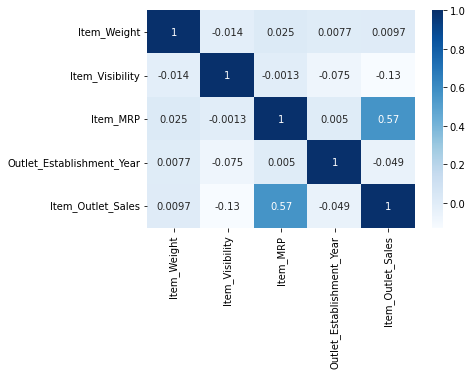

In [ ]:
sns.heatmap(corr,cmap='Blues', annot=True)

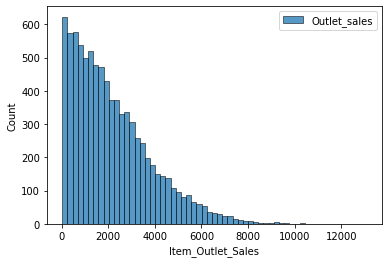

In [ ]:
sns.histplot(df['Item_Outlet_Sales'], label = 'Outlet_sales')
plt.legend();

# we see a tail distribution